In [1]:
import numpy as np
import os
import torch
import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
pd.set_option('display.float_format', lambda x: '%.3g' % x if np.log10(x) > -1.5 else '%.1e' % x )
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

def get_batchsize_list(N):
    s = 4
    ns = []
    for i in range(3, int(np.log2(N))+1):
        b = 2**i // s
        niters_per_layer = 8
        if i == 3: 
            niters_per_layer = 12
        elif i == int(np.log2(N)): 
            niters_per_layer = 10
        ns = ns + niters_per_layer*[b*b]
    return np.array(ns)

basepath = ""
# Below for copying results

In [2]:
def get_deformation_map(muYL, data, offsets, s):
    shape = muYL.shape
    b1, b2 = shape[0]//s, shape[1]//s
    B, w, h = data.shape
    W, H = shape
    b1 = b2 = 32
    weights = torch.zeros((b1, b2))
    weights[::2,::2] = 1
    weights[1::2,::2] = 2
    weights[::2,1::2] = 3
    weights[1::2,1::2] = 4
    weights = weights.view(b1, 1, b1, 1).expand(-1, W//(32*s), -1, H//(32*s)).contiguous().ravel()

    # Deformation map
    def_map = torch.zeros_like(muYL)
    PYpi = torch.zeros_like(muYL)
    for i in range(B):
        l, b = offsets[i]
        wi = min(l+w,W) - l
        hi = min(b+h,H) - b
        def_map[l:l+wi, b:b+hi] += data[i,:wi,:hi] * weights[i]
        PYpi[l:l+wi, b:b+hi] += data[i,:wi,:hi]
    
    # Renormalize
    def_map = def_map / PYpi
    return def_map


In [5]:
reaches = [1/64, 1/16, 1/4, 1.0, 4.0, 16.0]
def_maps = dict()

for reach in reaches: 
    for N in [256]:
        tag1 = "000"
        tag2 = "001"
        fname = f"../examples/results/domdec-reach-{reach}-{N:04d}-{tag1}-{tag2}-dumpfinest.pickle"
        with open(fname, "rb") as f:
            muXL, muYL, eps, dxs_dys, data, offsets, muXA, alphaA, muXB, alphaB \
                = pickle.load(f)
        
        def_maps[(N, reach)] = get_deformation_map(muYL, data, offsets, 4)

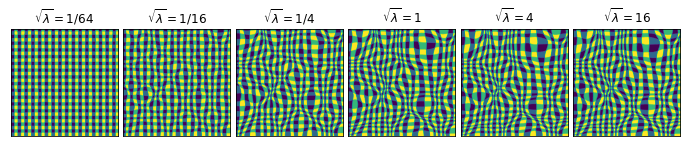

In [6]:
def format_reach(x): return str(int(x)) if x >= 1 else f"1/{int(1/x)}"
s = 2
fig, axs = plt.subplots(nrows = 1, ncols = 6, figsize = (6*s, s))
axs = axs.ravel()
N = 256
for j, reach in enumerate([1/64, 1/16, 1/4, 1, 4, 16]):
    axs[j].imshow(def_maps[(N, reach)])
    axs[j].set_xticks([])
    axs[j].set_yticks([])
    axs[j].set_title(r"$\sqrt{\lambda} = " +rf"{format_reach(reach)}$")
    # axs[i,0].set_ylabel(f"$N = {N}$", fontsize = 16)
plt.subplots_adjust(wspace = 0.05, hspace = 0.05)

plt.savefig(basepath + "deformation-map.pdf",
            bbox_inches = "tight", dpi = 300)
plt.show()